# Unsupervised image denoising

## Import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## Load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_08_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

train       = data['x_train'] 
train_noise = data['x_train_noise']

test        = data['x_test'] 
test_noise  = data['x_test_noise']

num_train   = train.shape[0]
num_test    = test.shape[0]

In [3]:
print('*************************************************')
print('size of train :', train.shape)
print('size of train_noise :', train_noise.shape)
print('*************************************************')
print('size of test :', test.shape)
print('size of test_noise :', test_noise.shape)
print('*************************************************')

*************************************************
size of train : (10000, 32, 32)
size of train_noise : (10000, 32, 32)
*************************************************
size of test : (5000, 32, 32)
size of test_noise : (5000, 32, 32)
*************************************************


## plot examples of the data

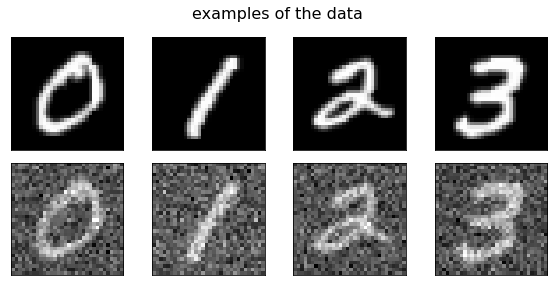

In [4]:
nRow = 2
nCol = 4
size = 2

title       = 'examples of the data'
fig, axes   = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
fig.suptitle(title, fontsize=16)

for c in range(nCol):

    axes[0, c].imshow(train[c * 1000], cmap='gray')
    axes[1, c].imshow(train_noise[c * 1000], cmap='gray')

    axes[0, c].xaxis.set_visible(False)
    axes[1, c].xaxis.set_visible(False)
    
    axes[0, c].yaxis.set_visible(False)
    axes[1, c].yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## custom data loader for the PyTorch framework

In [5]:
class dataset(Dataset):
    
    def __init__(self, image, image_noise):
        
        self.image          = image
        self.image_noise    = image_noise
    
    def __getitem__(self, index):
        
        image       = self.image[index]
        image_noise = self.image_noise[index]

        image       = torch.FloatTensor(image).unsqueeze(dim=0)
        image_noise = torch.FloatTensor(image_noise).unsqueeze(dim=0)

        return (image, image_noise)
    
    def __len__(self):

        number_image = self.image.shape[0]

        return number_image

## setting device

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [7]:
print(device)

cuda


In [8]:
# random seed
import random
random.seed(20184757)
np.random.seed(20184757)
torch.manual_seed(20184757)
torch.cuda.manual_seed(20184757)
torch.cuda.manual_seed_all(20184757)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## construct datasets and dataloaders for testing and testing

In [9]:
# ================================================== 
# determine your own parameter value
#
size_minibatch      = 32
#
# ================================================== 

dataset_train       = dataset(train, train_noise)
dataset_test        = dataset(test, test_noise)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True)

## shape of the data when using the data loader

In [9]:
train_image, train_image_noise = next(iter(dataloader_train))
test_image, test_image_noise = next(iter(dataloader_test))

In [10]:
print('************************************************************')
print('size of mini-batch of the training image:', train_image.shape)
print('************************************************************')
print('size of mini-batch of the training image_noise:', train_image_noise.shape)
print('************************************************************')
print('size of mini-batch of the testing image:', test_image.shape)
print('************************************************************')
print('size of mini-batch of the testing image_noise:', test_image_noise.shape)
print('************************************************************')

************************************************************
size of mini-batch of the training image: torch.Size([32, 1, 32, 32])
************************************************************
size of mini-batch of the training image_noise: torch.Size([32, 1, 32, 32])
************************************************************
size of mini-batch of the testing image: torch.Size([32, 1, 32, 32])
************************************************************
size of mini-batch of the testing image_noise: torch.Size([32, 1, 32, 32])
************************************************************


## construct a neural network 

In [10]:
# # ================================================== 
# # define your own neural network architecture and initialization
# #
# class Network(nn.Module):
#     def __init__(self):
#         super(Network,self).__init__()

#         # -------------------------------------------------
#         # Encoder
#         # -------------------------------------------------
#         self.encoder_layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),  
#             nn.MaxPool2d(2,2),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#         )
        
#         self.encoder_layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.MaxPool2d(2,2),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#         )

#         # -------------------------------------------------
#         # Decoder
#         # -------------------------------------------------
#         self.decoder_layer2 = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#         )
        
#         self.decoder_layer1 = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.Sigmoid(),
#         )

#         # -------------------------------------------------
#         # Network
#         # -------------------------------------------------
#         self.network = nn.Sequential(
#             self.encoder_layer1,
#             self.encoder_layer2,
#             self.decoder_layer2, 
#             self.decoder_layer1,
#         )
        
#         self.initialize_weight()

#     def forward(self,x):
    
#         out = self.network(x)
      
#         return out

#     # ======================================================================
#     # initialize weights
#     # ======================================================================
#     def initialize_weight(self):
            
#         for m in self.network.modules():
            
#             if isinstance(m, nn.Conv2d):

#                 nn.init.xavier_uniform_(m.weight) 
#                 if m.bias is not None:

#                     nn.init.constant_(m.bias, 1)
#                     pass
                    
#             elif isinstance(m, nn.BatchNorm2d):
                
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 1)
                
#             elif isinstance(m, nn.Linear):

#                 nn.init.xavier_uniform_(m.weight)

#                 if m.bias is not None:
                    
#                     nn.init.constant_(m.bias, 1)
#                     pass
# #
# # ================================================== 

class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
    
        self.encoder_layer1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
        )
        self.encoder_layer2 = nn.Sequential(
                        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
        )
        self.encoder_layer3 = nn.Sequential(
                        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True),
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
        )
            
        self.decoder_layer3 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True, output_padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
        )
        self.decoder_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True, output_padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
        )
        self.decoder_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=2, padding=1, bias=True, output_padding=1),
                        nn.Sigmoid(),
        )

        self.network = nn.Sequential(
            self.encoder_layer1,
            self.encoder_layer2,
            self.encoder_layer3,
            self.decoder_layer3,
            self.decoder_layer2, 
            self.decoder_layer1,
        )
        
        self.initialize_weight()

    def forward(self,x):
        out = self.network(x)
        return out

    def initialize_weight(self):
        for m in self.network.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 1)
                    pass
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 1)
                    pass

## build the network

In [11]:
# ================================================== 
# determine your own parameter value
#
learning_rate   = 0.03
weight_decay    = 0.0001
alpha           = 0.0001
number_epoch    = 200
#
# ================================================== 

model       = Network().to(device)
optimizer   = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## compute the prediction

In [12]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

## compute the data fidelity term
- use the mean squared error for the data fidelity term
- use the following loss function `nn.MSELoss()`
- input dimension: mini-batch-size x channel x height x width

In [13]:
def compute_loss_data_fidelity(prediction, original):
    # ================================================== 
    # fill up the blank
    #    
    loss = nn.MSELoss()(prediction, original)
    #
    # ================================================== 

    return loss

## compute the regularization term
- use the total variation for the regularization term
- use the following loss function: $\frac{1}{n} \sum_{x, y} \lvert \frac{\partial}{\partial x} f(x, y) \rvert + \frac{1}{n} \sum_{x, y} \lvert \frac{\partial}{\partial y} f(x, y) \rvert$
- use the neumann boundary condition (gradient of the boundary to the normal direction is zero)

In [14]:
def compute_loss_regularization(prediction):
    # ================================================== 
    # fill up the blank
    #    
    loss = torch.divide(
        torch.sum(torch.abs(prediction[:,:,1:,:] - prediction[:,:,:-1,:])) 
        + torch.sum(torch.abs(prediction[:,:,:,1:] - prediction[:,:,:,:-1])), 
        prediction.shape[0]
    )
    #
    # ================================================== 

    return loss

## compute the total loss
- total loss = data fidelity + $\alpha$ * regularization
- $\alpha \in \mathbb{R}$

In [15]:
def compute_loss(prediction, original, alpha):
    # ================================================== 
    # fill up the blank
    #    
    loss_data_fidelity  = compute_loss_data_fidelity(prediction, original)
    loss_regularization = compute_loss_regularization(prediction)

    loss = loss_data_fidelity + alpha * loss_regularization
    #
    # ================================================== 

    return (loss, loss_data_fidelity, loss_regularization)

## compute the loss value

In [16]:
def compute_loss_value(loss):
    
    loss_value = loss.item()
    
    return loss_value

## compute the PSNR metric

- input dimension: mini-batch-size x channel x height x width
- psnr is defined by $10 * \log_{10}(\frac{1}{\textrm{MSE}})$
- MSE is defined by $\textrm{MSE}(x, y) = \frac{1}{n} \| x - y \|_2^2$ where $n$ is the length of data $x$ and $y$

In [17]:
def compute_psnr(data1, data2):

    mse         = nn.MSELoss()(data1, data2)
    mse_value   = mse.item()
    psnr        = 10 * np.log10(1 / mse_value)

    return psnr

## Variable for the learning curves

In [18]:
loss_train_mean = np.zeros(number_epoch)
loss_train_std  = np.zeros(number_epoch)
psnr_train_mean = np.zeros(number_epoch)
psnr_train_std  = np.zeros(number_epoch)

loss_test_mean  = np.zeros(number_epoch)
loss_test_std   = np.zeros(number_epoch)
psnr_test_mean  = np.zeros(number_epoch)
psnr_test_std   = np.zeros(number_epoch)

loss_train_data_fidelity_mean   = np.zeros(number_epoch)
loss_train_data_fidelity_std    = np.zeros(number_epoch)
loss_train_regularization_mean  = np.zeros(number_epoch)
loss_train_regularization_std   = np.zeros(number_epoch)

loss_test_data_fidelity_mean    = np.zeros(number_epoch)
loss_test_data_fidelity_std     = np.zeros(number_epoch)
loss_test_regularization_mean   = np.zeros(number_epoch)
loss_test_regularization_std    = np.zeros(number_epoch)

## train

In [19]:
def train(model, optimizer, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    psnr_epoch                  = []

    model.train()

    for index_batch, (image, image_noise) in enumerate(dataloader):

        image       = image.to(device)
        image_noise = image_noise.to(device)

        # ================================================== 
        # fill up the blank
        #               
        prediction                  = compute_prediction(model, image_noise)
        loss_all                    = compute_loss(prediction, image_noise, alpha)
        loss_value                  = compute_loss_value(loss_all[0])
        loss_data_fidelity_value    = compute_loss_value(loss_all[1])
        loss_regularization_value   = compute_loss_value(loss_all[2])
        psnr                        = compute_psnr(prediction, image)
        #
        # ================================================== 

        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        psnr_epoch.append(psnr)

        # ================================================== 
        # fill up the blank (update moodel parameters)
        #       
        optimizer.zero_grad()
        loss_all[0].backward()
        optimizer.step()
        #
        # ==================================================  

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    psnr_mean   = np.mean(psnr_epoch)
    psnr_std    = np.std(psnr_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    psnr                = {'mean' : psnr_mean, 'std' : psnr_std}

    return (loss, loss_data_fidelity, loss_regularization, psnr)

## test

In [20]:
def test(model, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    psnr_epoch                  = []

    model.eval()

    for index_batch, (image, image_noise) in enumerate(dataloader):
    
        image       = image.to(device)
        image_noise = image_noise.to(device)

        # ================================================== 
        # fill up the blank
        #               
        prediction                  = compute_prediction(model, image_noise)
        loss_all                    = compute_loss(prediction, image_noise, alpha)
        loss_value                  = compute_loss_value(loss_all[0])
        loss_data_fidelity_value    = compute_loss_value(loss_all[1])
        loss_regularization_value   = compute_loss_value(loss_all[2])
        psnr                        = compute_psnr(prediction, image)
        #
        # ================================================== 

        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        psnr_epoch.append(psnr)

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    psnr_mean   = np.mean(psnr_epoch)
    psnr_std    = np.std(psnr_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    psnr                = {'mean' : psnr_mean, 'std' : psnr_std}

    return (loss, loss_data_fidelity, loss_regularization, psnr)

## train and test

In [21]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, loss_data_fidelity_train, loss_regularization_train, psnr_train) = train(model, optimizer, dataloader_train)

    loss_train_mean[i]  = loss_train['mean']
    loss_train_std[i]   = loss_train['std']

    loss_train_data_fidelity_mean[i]    = loss_data_fidelity_train['mean']
    loss_train_data_fidelity_std[i]     = loss_data_fidelity_train['std']

    loss_train_regularization_mean[i]   = loss_regularization_train['mean']
    loss_train_regularization_std[i]    = loss_regularization_train['std']

    psnr_train_mean[i]  = psnr_train['mean']
    psnr_train_std[i]   = psnr_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, loss_data_fidelity_test, loss_regularization_test, psnr_test) = test(model, dataloader_test)

    loss_test_mean[i]  = loss_test['mean']
    loss_test_std[i]   = loss_test['std']

    loss_test_data_fidelity_mean[i]    = loss_data_fidelity_test['mean']
    loss_test_data_fidelity_std[i]     = loss_data_fidelity_test['std']

    loss_test_regularization_mean[i]   = loss_regularization_test['mean']
    loss_test_regularization_std[i]    = loss_regularization_test['std']

    psnr_test_mean[i]  = psnr_test['mean']
    psnr_test_std[i]   = psnr_test['std']

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:47<00:00,  3.54s/it]


---

## functions for presenting the results

---

In [22]:
def function_result_01():
    
    title           = 'loss (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_mean)), loss_train_mean - loss_train_std, loss_train_mean + loss_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [23]:
def function_result_02():
    
    title           = 'loss - data fidelity (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean - loss_train_data_fidelity_std, loss_train_data_fidelity_mean + loss_train_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [24]:
def function_result_03():
    
    title           = 'loss - regularization (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_regularization_mean)), loss_train_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_regularization_mean)), loss_train_regularization_mean - loss_train_regularization_std, loss_train_regularization_mean + loss_train_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [25]:
def function_result_04():
    
    title           = 'loss (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_mean)), loss_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_mean)), loss_test_mean - loss_test_std, loss_test_mean + loss_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [26]:
def function_result_05():
    
    title           = 'loss - data fidelity (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean - loss_test_data_fidelity_std, loss_test_data_fidelity_mean + loss_test_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [27]:
def function_result_06():
    
    title           = 'loss - regularization (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_regularization_mean)), loss_test_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_regularization_mean)), loss_test_regularization_mean - loss_test_regularization_std, loss_test_regularization_mean + loss_test_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [28]:
def function_result_07():
    
    title           = 'psnr (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(psnr_train_mean)), psnr_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(psnr_train_mean)), psnr_train_mean - psnr_train_std, psnr_train_mean + psnr_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [29]:
def function_result_08():
    
    title           = 'psnr (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(psnr_test_mean)), psnr_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(psnr_test_mean)), psnr_test_mean - psnr_test_std, psnr_test_mean + psnr_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [30]:
def function_result_09():

    nRow = 9
    nCol = 3
    size = 3 
    
    title = 'training results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    index_image = np.array([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])

    image           = torch.FloatTensor(dataset_train.image[index_image]).unsqueeze(dim=1).to(device)
    image_noise     = torch.FloatTensor(dataset_train.image_noise[index_image]).unsqueeze(dim=1).to(device)
    image_denoise   = compute_prediction(model, image_noise)

    image           = image.detach().cpu().squeeze(axis=1)
    image_noise     = image_noise.detach().cpu().squeeze(axis=1)
    image_denoise   = image_denoise.detach().cpu().squeeze(axis=1)

    nStep = 3
    
    for r in range(3):
        for c in range(nCol):

            axes[0 + r * nStep, c].imshow(image_noise[c + r * nStep], cmap='gray')
            axes[1 + r * nStep, c].imshow(image[c + r * nStep], cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(image_denoise[c + r * nStep], cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
            
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

In [31]:
def function_result_10():
    
    nRow = 9 
    nCol = 3
    size = 3
    
    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    index_image     = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])
    
    image           = torch.FloatTensor(dataset_test.image[index_image]).unsqueeze(dim=1).to(device)
    image_noise     = torch.FloatTensor(dataset_test.image_noise[index_image]).unsqueeze(dim=1).to(device)
    image_denoise   = compute_prediction(model, image_noise)

    image           = image.detach().cpu().squeeze(axis=1)
    image_noise     = image_noise.detach().cpu().squeeze(axis=1)
    image_denoise   = image_denoise.detach().cpu().squeeze(axis=1)

    nStep = 3

    for r in range(3):
        for c in range(nCol):

            axes[0 + r * nStep, c].imshow(image_noise[c + r * nStep], cmap='gray')
            axes[1 + r * nStep, c].imshow(image[c + r * nStep], cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(image_denoise[c + r * nStep], cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
            
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

In [32]:
def function_result_11():
    
    print('final training psnr = %9.8f' % (psnr_train_mean[-1]))

In [33]:
def function_result_12():
    
    print('final testing psnr = %9.8f' % (psnr_test_mean[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



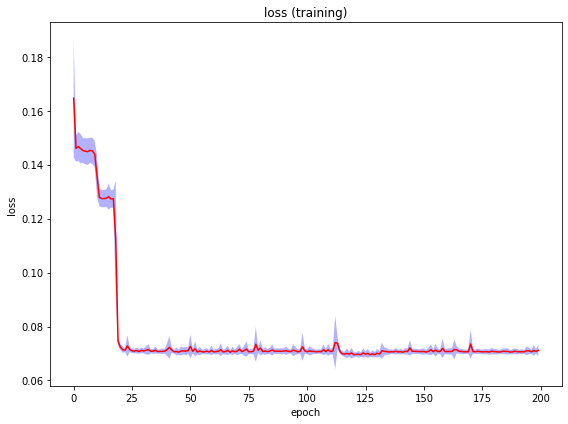


################################################################################
#
# RESULT # 02
#
################################################################################



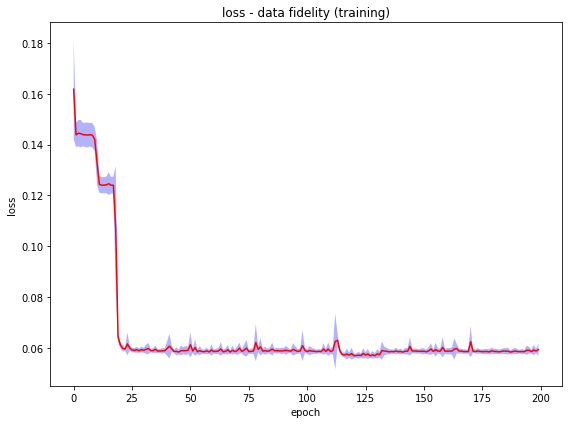


################################################################################
#
# RESULT # 03
#
################################################################################



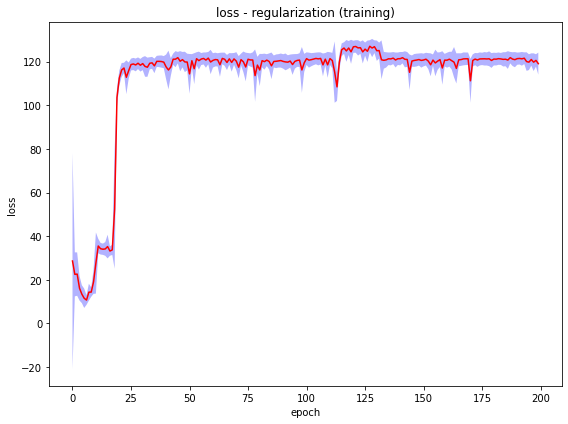


################################################################################
#
# RESULT # 04
#
################################################################################



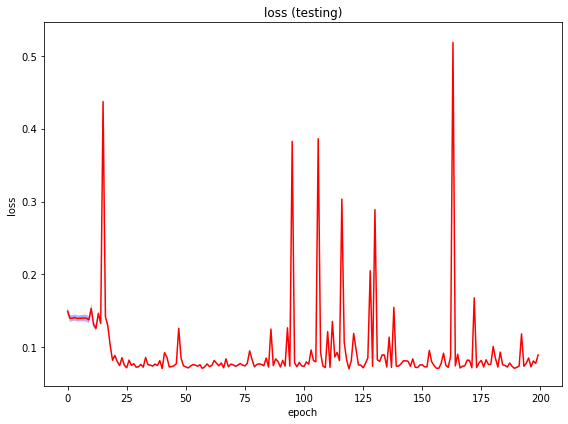


################################################################################
#
# RESULT # 05
#
################################################################################



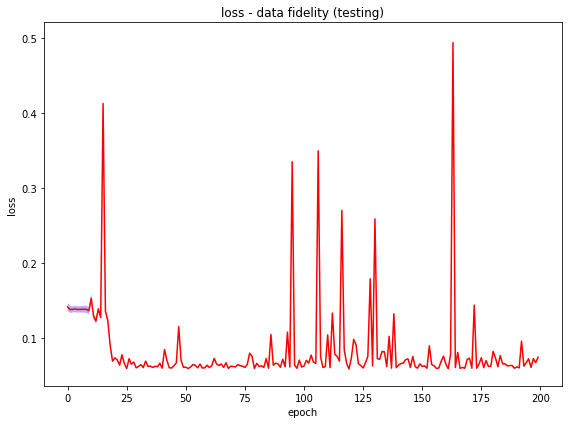


################################################################################
#
# RESULT # 06
#
################################################################################



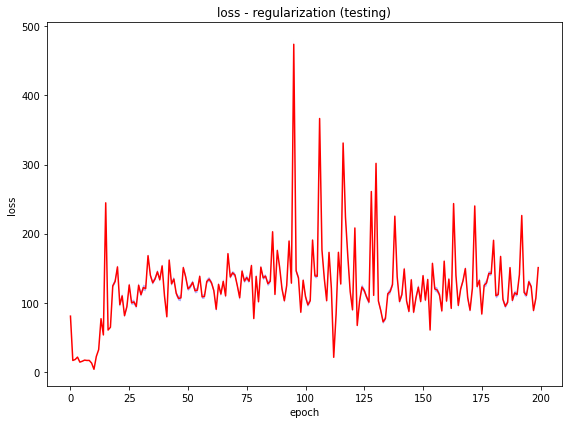


################################################################################
#
# RESULT # 07
#
################################################################################



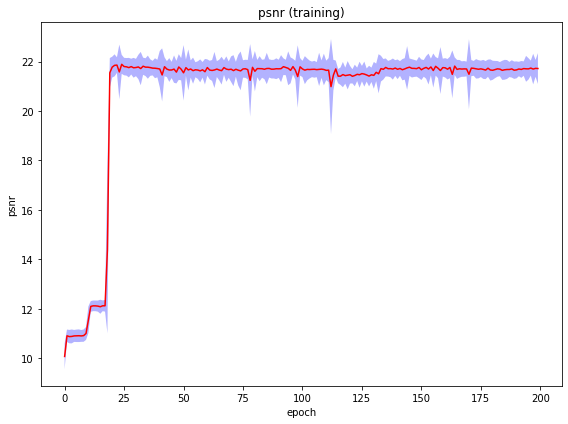


################################################################################
#
# RESULT # 08
#
################################################################################



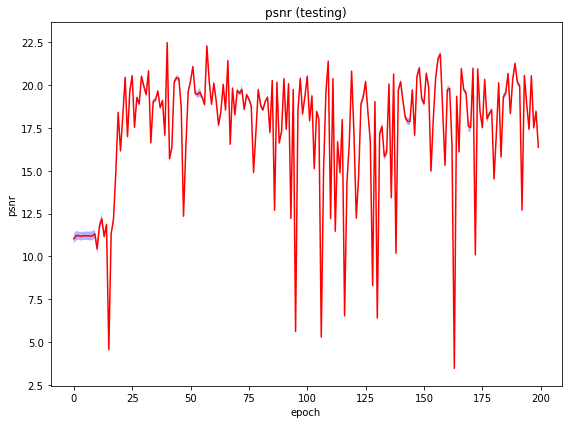


################################################################################
#
# RESULT # 09
#
################################################################################



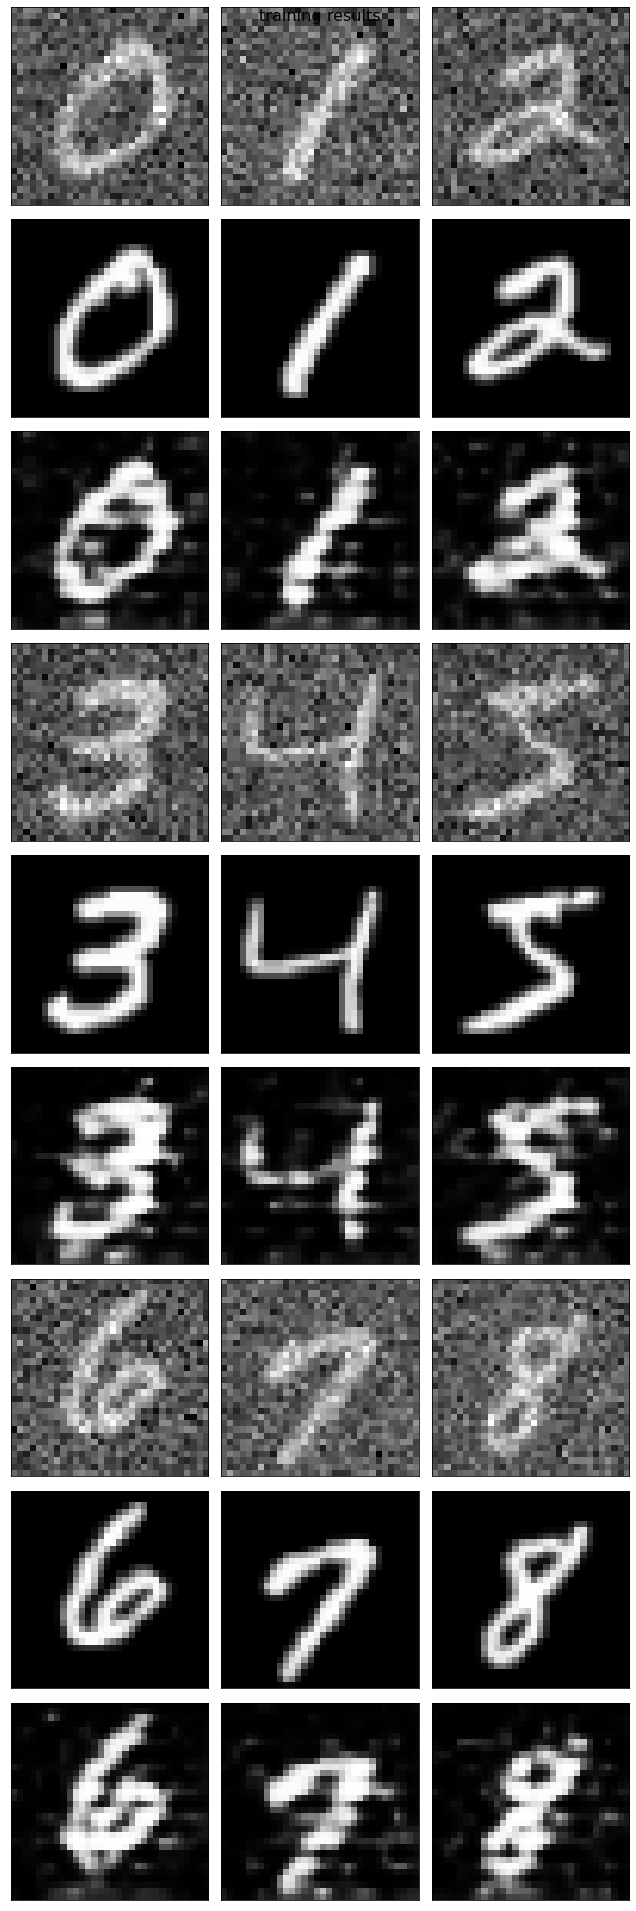


################################################################################
#
# RESULT # 10
#
################################################################################



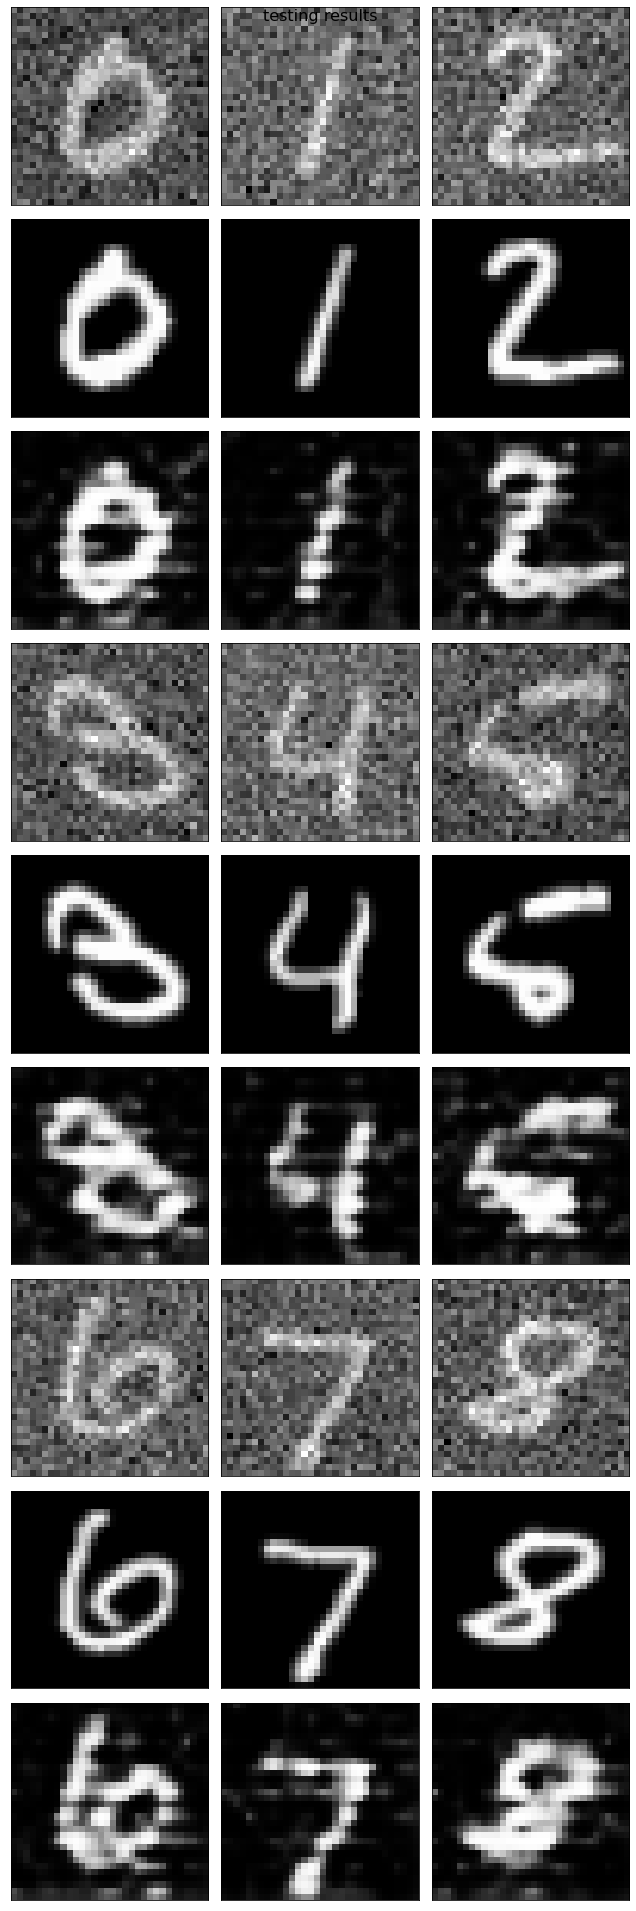


################################################################################
#
# RESULT # 11
#
################################################################################

final training psnr = 21.71704611

################################################################################
#
# RESULT # 12
#
################################################################################

final testing psnr = 16.36535214


In [34]:
number_result = 12 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)

In [13]:
import gc
import random

In [14]:
directory_data  = './'
filename_data   = 'assignment_08_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

train_data       = data['x_train'] 
train_noise = data['x_train_noise']

test_data        = data['x_test'] 
test_noise  = data['x_test_noise']

num_train   = train_data.shape[0]
num_test    = test_data.shape[0]

# random seed
random.seed(20184757)
np.random.seed(20184757)
torch.manual_seed(20184757)
torch.cuda.manual_seed(20184757)
torch.cuda.manual_seed_all(20184757)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ================================================== 
# determine your own parameter value
#
size_minibatch      = 32
#
# ================================================== 

dataset_train       = dataset(train_data, train_noise)
dataset_test        = dataset(test_data, test_noise)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True)



class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
    
        self.encoder_layer1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
        )
        self.encoder_layer2 = nn.Sequential(
                        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
        )
        self.encoder_layer3 = nn.Sequential(
                        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True),
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
        )
            
        self.decoder_layer3 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True, output_padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
        )
        self.decoder_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True, output_padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
        )
        self.decoder_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=2, padding=1, bias=True, output_padding=1),
                        nn.Sigmoid(),
        )

        self.network = nn.Sequential(
            self.encoder_layer1,
            self.encoder_layer2,
            self.encoder_layer3,
            self.decoder_layer3,
            self.decoder_layer2, 
            self.decoder_layer1,
        )
        
        self.initialize_weight()

    def forward(self,x):
        out = self.network(x)
        return out

    def initialize_weight(self):
        for m in self.network.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 1)
                    pass
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 1)
                    pass
                
    
    
    # ================================================== 
# determine your own parameter value
#

lr = [0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
al = [0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
wd = [0.001, 0.0001, 0.00001]

for lrx in lr:
    for alx in al:
        for wdx in wd:


            learning_rate   = lrx
            weight_decay    = wdx
            alpha           = alx
            number_epoch    = 200
            #
            # ================================================== 

            model       = Network().to(device)
            optimizer   = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            loss_train_mean = np.zeros(number_epoch)
            loss_train_std  = np.zeros(number_epoch)
            psnr_train_mean = np.zeros(number_epoch)
            psnr_train_std  = np.zeros(number_epoch)

            loss_test_mean  = np.zeros(number_epoch)
            loss_test_std   = np.zeros(number_epoch)
            psnr_test_mean  = np.zeros(number_epoch)
            psnr_test_std   = np.zeros(number_epoch)

            loss_train_data_fidelity_mean   = np.zeros(number_epoch)
            loss_train_data_fidelity_std    = np.zeros(number_epoch)
            loss_train_regularization_mean  = np.zeros(number_epoch)
            loss_train_regularization_std   = np.zeros(number_epoch)

            loss_test_data_fidelity_mean    = np.zeros(number_epoch)
            loss_test_data_fidelity_std     = np.zeros(number_epoch)
            loss_test_regularization_mean   = np.zeros(number_epoch)
            loss_test_regularization_std    = np.zeros(number_epoch)
            
            
            # ================================================================================
            # 
            # iterations for epochs
            #
            # ================================================================================
            for i in tqdm(range(number_epoch)):

                # ================================================================================
                # 
                # training
                #
                # ================================================================================
                (loss_train, loss_data_fidelity_train, loss_regularization_train, psnr_train) = train(model, optimizer, dataloader_train)

                loss_train_mean[i]  = loss_train['mean']
                loss_train_std[i]   = loss_train['std']

                loss_train_data_fidelity_mean[i]    = loss_data_fidelity_train['mean']
                loss_train_data_fidelity_std[i]     = loss_data_fidelity_train['std']

                loss_train_regularization_mean[i]   = loss_regularization_train['mean']
                loss_train_regularization_std[i]    = loss_regularization_train['std']

                psnr_train_mean[i]  = psnr_train['mean']
                psnr_train_std[i]   = psnr_train['std']

                # ================================================================================
                # 
                # testing
                #
                # ================================================================================
                (loss_test, loss_data_fidelity_test, loss_regularization_test, psnr_test) = test(model, dataloader_test)

                loss_test_mean[i]  = loss_test['mean']
                loss_test_std[i]   = loss_test['std']

                loss_test_data_fidelity_mean[i]    = loss_data_fidelity_test['mean']
                loss_test_data_fidelity_std[i]     = loss_data_fidelity_test['std']

                loss_test_regularization_mean[i]   = loss_regularization_test['mean']
                loss_test_regularization_std[i]    = loss_regularization_test['std']

                psnr_test_mean[i]  = psnr_test['mean']
                psnr_test_std[i]   = psnr_test['std']
                
                
            print(np.max(psnr_test_mean), np.argmax(psnr_test_mean), lrx, alx, wdx)
            gc.collect()

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:46<00:00,  3.53s/it]


0.7339074380020245 9 0.1 0.1 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:49<00:00,  3.55s/it]


0.7262765103639338 197 0.1 0.1 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:47<00:00,  3.54s/it]


1.8171950022289258 9 0.1 0.1 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:54<00:00,  3.57s/it]


2.2440394168421074 47 0.1 0.03 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:54<00:00,  3.57s/it]


0.739883438292343 12 0.1 0.03 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:57<00:00,  3.59s/it]


0.8140666720031219 101 0.1 0.03 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:56<00:00,  3.58s/it]


1.247578083790298 30 0.1 0.01 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:47<00:00,  3.54s/it]


5.497720943289488 1 0.1 0.01 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:51<00:00,  3.56s/it]


10.283576652459613 27 0.1 0.01 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [12:11<00:00,  3.66s/it]


11.040240185639275 2 0.1 0.003 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [12:09<00:00,  3.65s/it]


3.7956037821923894 193 0.1 0.003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [12:29<00:00,  3.75s/it]


10.282649264888379 184 0.1 0.003 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:45<00:00,  3.53s/it]


11.052035720158555 137 0.1 0.001 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:37<00:00,  3.49s/it]


15.174619065918474 2 0.1 0.001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:40<00:00,  3.50s/it]


10.30985800083738 7 0.1 0.001 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:38<00:00,  3.49s/it]


16.50358259826509 2 0.1 0.0003 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:44<00:00,  3.52s/it]


19.682481413705766 187 0.1 0.0003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:46<00:00,  3.53s/it]


10.322727973314748 161 0.1 0.0003 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:39<00:00,  3.50s/it]


17.137950232859637 94 0.1 0.0001 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:45<00:00,  3.53s/it]


20.411468242854284 109 0.1 0.0001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:44<00:00,  3.52s/it]


21.84717182279195 125 0.1 0.0001 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:48<00:00,  3.54s/it]


0.7310587510207903 169 0.03 0.1 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:48<00:00,  3.54s/it]


0.7265065505257428 144 0.03 0.1 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:50<00:00,  3.55s/it]


0.7262489395048357 34 0.03 0.1 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:49<00:00,  3.55s/it]


11.051116767257097 62 0.03 0.03 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [12:19<00:00,  3.70s/it]


0.7927003460812899 163 0.03 0.03 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:47<00:00,  3.54s/it]


0.7263702708295607 194 0.03 0.03 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:42<00:00,  3.51s/it]


11.052692959587784 159 0.03 0.01 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:46<00:00,  3.53s/it]


10.293890246358247 60 0.03 0.01 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:46<00:00,  3.53s/it]


0.7432848125646202 94 0.03 0.01 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:41<00:00,  3.51s/it]


11.054243064051116 174 0.03 0.003 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:50<00:00,  3.55s/it]


11.053693516334992 56 0.03 0.003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [12:51<00:00,  3.86s/it]


10.55992233957943 181 0.03 0.003 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:57<00:00,  3.59s/it]


11.052581731562446 75 0.03 0.001 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:53<00:00,  3.57s/it]


11.054095996336992 72 0.03 0.001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:50<00:00,  3.55s/it]


11.053204459906539 77 0.03 0.001 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:49<00:00,  3.55s/it]


19.353955795988476 1 0.03 0.0003 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:46<00:00,  3.53s/it]


21.434202851717252 59 0.03 0.0003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:43<00:00,  3.52s/it]


11.191531416455401 57 0.03 0.0003 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:41<00:00,  3.51s/it]


20.403855824314775 159 0.03 0.0001 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:41<00:00,  3.51s/it]


22.41862338983881 166 0.03 0.0001 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:41<00:00,  3.51s/it]


21.449052077155663 1 0.03 0.0001 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:41<00:00,  3.51s/it]


11.052569487429183 136 0.01 0.1 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:34<00:00,  3.47s/it]


0.7264167124434704 31 0.01 0.1 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:40<00:00,  3.50s/it]


0.7265304712007856 0 0.01 0.1 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:33<00:00,  3.47s/it]


11.053512298452556 172 0.01 0.03 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:50<00:00,  3.55s/it]


11.052421882015523 134 0.01 0.03 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:54<00:00,  3.57s/it]


0.7272526226455424 0 0.01 0.03 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:39<00:00,  3.50s/it]


11.05421347266548 21 0.01 0.01 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:42<00:00,  3.51s/it]


11.053772367240786 24 0.01 0.01 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:41<00:00,  3.51s/it]


11.052298005822394 61 0.01 0.01 1e-05


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:45<00:00,  3.53s/it]


11.180750620806013 2 0.01 0.003 0.001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:36<00:00,  3.48s/it]


11.0530362182393 132 0.01 0.003 0.0001


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [11:43<00:00,  3.52s/it]


11.07140899745779 28 0.01 0.003 1e-05


 10%|███████▊                                                                          | 19/200 [01:08<10:56,  3.63s/it]


KeyboardInterrupt: 